# Instalação e autenticação

In [ ]:
!pip install -q ffmpeg-python
!pip install -q cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 50.1 MB/s eta 0:00:00


In [ ]:
import ee
import geemap
ee.Authenticate()

ee.Initialize(project='ee-mateussayao')

# Contrução do Polígono

In [ ]:
monitoring_polygon = {
    'geodesic': False,
    'type': 'Polygon',
    'coordinates': [ #[longitude, latitude]
        [
           [-60.998611, -64.137778],
           [-60.865278, -64.137778],
           [-60.865278, -64.183333],
           [-60.998611, -64.183333],
           [-60.998611, -64.137778]
        ]
    ]
}
# Criar o objeto ee.Geometry.Polygon
#NOMEAR POLÍGONO DO ROI
roi_cierva_cove = ee.Geometry.Polygon( #MUDAR ROI
    coords=monitoring_polygon['coordinates'],
    proj=ee.Projection('EPSG:4326'),
    geodesic=monitoring_polygon['geodesic']
)

# Importação de Imagens

In [ ]:
# escolhendo as imagens do repositório
collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterDate("2024-03-01", "2024-03-31")
    .filterBounds(roi_cierva_cove) #MUDAR ROI
)

count = collection.size().getInfo()
print(f'Número de imagens selecionadas no período:{count:.0f}')

Número de imagens selecionadas no período:18


# Construção do Dataframe
- O "'system:time_end' é um campo genérico do Earth Engine associado a imagens. O "segmentStartTime" é especifico do SAR
- É possivel verificar no catálogo do satélite que prorpiedade de imagens estão disponíveis. No caso "resolution" para o S2 não tem, então anulei a linha do código com #
- Inclui a propiedade de Porcentagem de Gelo

In [ ]:
#Importação de Bibliotecas:
from datetime import datetime
import pandas as pd
from tqdm import tqdm

# Converte a coleção em uma lista
image_list = collection.toList(count)

# Lista para armazenar os dados
data = []

# calcula a área do roi do Iceberg
roi_area = roi_cierva_cove.area(ee.ErrorMargin(1)).getInfo() #MUDAR ROI

# Usa tqdm para mostrar o progresso
for idx in tqdm(range(count), desc="Processando imagens"):
    image = ee.Image(image_list.get(idx))

    # Calcula a interseção da imagem com a ROI e a proporção da área da imagem dentro da ROI
    intersection = image.geometry().intersection(roi_cierva_cove, ee.ErrorMargin(1)) #MUDAR ROI
    proportion = (intersection.area(ee.ErrorMargin(1)).getInfo() / roi_area) * 100

    image_info = image.getInfo()

# Extração de Informações da Imagem

    # Extrai e formatar a data a partir de 'segmentStartTime'
    timestamp = image_info['properties']['system:time_end']
    date_time = datetime.utcfromtimestamp(timestamp / 1000).strftime('%Y-%m-%d %H:%M:%S')

    # Extrai bandas e concatenar nomes das bandas (cria uma string com os nomes das bandas)
    bands = image_info['bands']
    band_names = ', '.join([band['id'] for band in bands])

    # Extrai informações
    crs = bands[0]['crs'] if bands else None
    image_id = image_info['id']
    #resolution_meters = image_info['properties']['resolution_meters']

    # Extrai a porcentagem de neve/gelo se disponível
    snow_ice_percentage = image_info['properties'].get('SNOW_ICE_PERCENTAGE', 'N/A')


    # Adiciona as informações ao DataFrame (Armazena as informações extraídas em um dicionário e o adiciona à lista 'data')
    data.append({
        'Bands': band_names,
        'CRS': crs,
        'ID': image_id,
        'Date Time': date_time,
        #'Resolution (m)': resolution_meters,
        'Proportion': proportion,
        'Snow/Ice Percentage': snow_ice_percentage  # Adiciona a porcentagem de neve/gelo
    })

# Constrói o DataFrame (do pandas a partir da lista de dicionários 'data', contendo todas as informações extraídas das imagens)
df_sentinel = pd.DataFrame(data)

Processando imagens: 100%|██████████| 18/18 [00:13<00:00,  1.38it/s]


## Code para Filtrar o *dataframe*

In [ ]:
# Filtra as imagens que possuem 'S1A_IW' no ID (correspondente a 10m de resolução) e atualiza df_sentinel
df_sentinel = df_sentinel[df_sentinel['ID'].str.contains('S1A_IW')]

# Exibe as primeiras linhas do DataFrame filtrado (somente com imagens de 10m)
print(df_sentinel.head())

- "proportion" é quanto do ROI está contido na imagem

# Dataframe

In [ ]:
df_sentinel

,Bands,CRS,ID,Date Time,Proportion,Snow/Ice Percentage
0,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240301T132919_20...,2024-03-01 13:30:28,100.000000,0.019831
1,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240301T132919_20...,2024-03-01 13:30:22,58.763024,0.000618
2,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240305T130859_20...,2024-03-05 13:10:31,100.000000,0.000078
3,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240305T130859_20...,2024-03-05 13:10:24,58.762939,0.000255
4,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240308T131859_20...,2024-03-08 13:20:27,100.000000,0.225567
5,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240308T131859_20...,2024-03-08 13:20:21,58.762939,0.531176
6,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240311T132919_20...,2024-03-11 13:30:26,100.000000,7.480606
7,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240311T132919_20...,2024-03-11 13:30:21,58.763011,0.014662
8,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240315T130859_20...,2024-03-15 13:10:33,100.000000,0.253799
9,"B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, ...",EPSG:32720,COPERNICUS/S2_SR_HARMONIZED/20240315T130859_20...,2024-03-15 13:10:27,58.762939,0.066075


In [ ]:
image_id = df_sentinel['ID'][30]
print(image_id)

COPERNICUS/S2_SR_HARMONIZED/20241021T130859_20241021T130859_T20DNP


#LISTA IDS

## Verão 19-20
'20190213T132009_20190213T132006_T20DNP'
'20190223T131909_20190223T131936_T20DNP'
'20191210T131909_20191210T131903_T20DNP' #NUVEM
'20200228T131909_20200228T131906_T20DNP'
## Verão 20-21
'20201204T131909_20201204T131907_T20DNP'
'20201214T131909_20201214T131905_T20DNP' #NUVEM
'20210113T131909_20210113T131908_T20DNP'
'20210205T132929_20210205T132923_T20DNP'
'20210212T131909_20210212T131907_T20DNP' #NUVEM
'20210314T131909_20210314T131909_T20DNP'
## Verão 21-22
'20220118T131909_20220118T131904_T20DNP',
'20220128T131859_20220128T131902_T20DNP',
'20220319T131909_20220319T131908_T20DNP',
'20220302T132919_20220302T132921_T20DNP',
'20220319T131909_20220319T131908_T20DNP',
'20220329T131909_20220329T131907_T20DNP',
##Verão 22-23
'20221211T130859_20221211T130857_T20DNP',
'20230317T132929_20230317T132928_T20DNP',
'20230321T130909_20230321T130905_T20DNP',
##Verão 23-24
'20231202T132919_20231202T132919_T20DNP',
'20231206T130859_20231206T130855_T20DNP',
'20231209T131909_20231209T131903_T20DNP',
'20231229T131909_20231229T131908_T20DNP',
'20240111T132919_20240111T132920_T20DNP',
'20240115T130859_20240115T130857_T20DNP',
'20240325T130859_20240325T130900_T20DNP',

## INVERNO
## Inverno 18
## Inverno 19
'20190911T131909_20190911T131910_T20DNP',
'20191001T131909_20191001T131909_T20DNP', #NUVEM
## Inverno 20
'20200905T131909_20200905T131912_T20DNP', #NUVEM
'20201124T131909_20201124T131909_T20DNP', #NOVEMBRO
## Inverno 21
'20211122T132919_20211122T132921_T20DNP', #NOVEMBRO
## Inverno 22
'20220918T132929_20220918T132924_T20DNP',
'20221002T130859_20221002T130859_T20DNP',
'20221002T130859_20221002T130859_T20DNP',
## Inverno 23
'20230910T131909_20230910T131911_T20DNP',
'20230913T132929_20230913T132927_T20DNP',
'20230917T130909_20230917T130903_T20DNP',
'20230920T131909_20230920T131912_T20DNP',
## Inverno 24
'20241001T130859_20241001T130935_T20DNP',
'20241004T131909_20241004T131940_T20DNP', #NUVEM
'20241021T130859_20241021T130859_T20DNP', #NUVEM?(muito gelo)









# Seleção da Imagem e composição

In [ ]:
image = ee.Image(image_list.get(int(26)))

In [ ]:
# map = geemap.Map(center=(-60.998611, -64.137778), zoom=10)
# map.add_basemap("Esri.AntarcticBasemap")

# # Configura as opções de visualização para a imagem
# vis_params = {'bands': ['B12', 'B8A', 'B4'], 'gamma': 1.07, 'min': 13.0, 'max': 5391.0}

# def laplacian_sharpen(image):
#     laplacian_kernel = ee.Kernel.laplacian8(100000)
#     sharpened_image = image.convolve(laplacian_kernel)
#     return sharpened_image

# # Adiciona a camada da imagem ao mapa
# map.add_layer(image, vis_params)

# # Adiciona o polígono com borda ao mapa
# region_style = {
#     'color': '#FF0000',  # Cor da borda (preto)
#     'width': 1,         # Largura da borda
#     'lineType': 'solid',
#     'fillColor': 'none',  # Cor de preenchimento (transparente)
# }
# map.add_layer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# #Exibe o mapa
# map

In [ ]:
# # Definindo o mapa
# map = geemap.Map(center=(-60.998611, -64.137778), zoom=10)
# map.add_basemap("Esri.AntarcticBasemap")

# # Definir as opções de visualização para a imagem
# vis_params = {'bands': ['B4', 'B3', 'B2'], 'gamma': 1.07, 'min': 13.0, 'max': 5391.0}

# # Função para aplicar o filtro de Laplaciano (sharpen)
# def laplacian_sharpen(image):
#     laplacian_kernel = ee.Kernel.laplacian8(100000)
#     sharpened_image = image.convolve(laplacian_kernel)
#     return sharpened_image

# # Realiza o corte da imagem com base na ROI (Cierva Cove)
# clipped_image = image.clip(roi_cierva_cove)

# # Adicionar a imagem cortada ao mapa com os parâmetros de visualização
# map.addLayer(clipped_image, vis_params, "Imagem Cortada (ROI)")

# # Estilo para o polígono da ROI
# region_style = {
#     'color': '#FF0000',  # Cor da borda (vermelho)
#     'width': 1,         # Largura da borda
#     'lineType': 'solid',
#     'fillColor': 'none',  # Cor de preenchimento (transparente)
# }

# # Adicionar o polígono da ROI ao mapa
# map.add_layer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# # Exibir o mapa
# map.add_basemap('Esri.AntarcticBasemap')
# map

# Aplicação do Índice

## Indice a partir de valores fixos

In [ ]:
# # Criar o mapa base
# Map = geemap.Map(center=(-64.137778, -60.998611), zoom=10)
# Map.add_basemap("Esri.AntarcticBasemap")

# # Definir o polígono do ROI para Cierva Cove
# roi_cierva_cove = ee.Geometry.Polygon(
#   [[
#     [-60.998611, -64.137778],
#     [-60.865278, -64.137778],
#     [-60.865278, -64.183333],
#     [-60.998611, -64.183333],
#     [-60.998611, -64.137778]
#   ]]
# )

# # Carregar a coleção de imagens Sentinel-2
# collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
#     .filterBounds(roi_cierva_cove) \
#     .filterDate('2024-03-01', '2024-03-31') \
#     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# # Selecionar a primeira imagem disponível da coleção
# image = collection.first()

# # Definir a fórmula do índice personalizado para B2
# def calculate_custom_index(image):
#     b2 = image.select('B2')

#     # Definir os limites de neve (valores conhecidos de B2)
#     min_value = 6988  # Limite inferior (não neve)
#     max_value = 9208  # Limite superior (neve)

#     # Reescalar os valores entre 0 e 1 com base nos limites fornecidos
#     index = b2.subtract(min_value).divide(max_value - min_value).clamp(0, 1)

#     # Renomear a banda do índice personalizado
#     return image.addBands(index.rename('Custom_Index'))

# # Aplicar o cálculo do índice personalizado na imagem
# image_custom_index = calculate_custom_index(image)

# # Parâmetros de visualização para o índice personalizado
# custom_index_vis_params = {
#     'min': 0.0,  # Corresponde ao valor mínimo do índice (não neve)
#     'max': 1.0,  # Corresponde ao valor máximo do índice (neve)
#     'palette': ['black', 'white']  # Cores para visualização
# }

# # Adicionar a camada do índice personalizado ao mapa
# Map.addLayer(image_custom_index.select('Custom_Index'), custom_index_vis_params, 'Custom Index')

# # Adicionar o polígono ao mapa
# region_style = {
#     'color': '#FF0000',  # Cor da borda
#     'width': 1,
#     'lineType': 'solid',
#     'fillColor': 'none'  # Sem preenchimento
# }
# Map.addLayer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# # Exibir o mapa
# Map

## índice a partir de valores fixos e razão de bandas

In [ ]:
# # Carregar a coleção de imagens Sentinel-2
# collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
#     .filterBounds(roi_cierva_cove) \
#     .filterDate('2024-03-01', '2024-03-31') \
#     .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))

# # Selecionar a primeira imagem disponível da coleção
# image = collection.first()

# # Definir a fórmula do índice personalizado usando bandas do visível (B2, B3, B4)
# def calculate_custom_index(image):
#     b2 = image.select('B2')
#     b3 = image.select('B3')
#     b4 = image.select('B4')

#     # Valores máximos (neve) e mínimos (não neve) para cada banda
#     max_b2, max_b3, max_b4 = 9208, 9176, 9416
#     min_b2, min_b3, min_b4 = 6988, 6996, 7052

#     # Normalizar as bandas com base nos valores de neve e não neve
#     norm_b2 = b2.subtract(min_b2).divide(max_b2 - min_b2)
#     norm_b3 = b3.subtract(min_b3).divide(max_b3 - min_b3)
#     norm_b4 = b4.subtract(min_b4).divide(max_b4 - min_b4)

#     # Calcular a média normalizada das três bandas
#     index = norm_b2.add(norm_b3).add(norm_b4).divide(3).clamp(0, 1)

#     # Renomear a banda do índice personalizado
#     return image.addBands(index.rename('Custom_Snow_Index'))

# # Aplicar o cálculo do índice personalizado na imagem
# image_custom_index = calculate_custom_index(image)

# # Parâmetros de visualização para o índice personalizado
# custom_index_vis_params = {
#     'min': 0.0,  # Não neve
#     'max': 1.0,  # Neve
#     'palette': ['black', 'white']  # Preto para não neve, branco para neve
# }

# # Adicionar a camada do índice personalizado ao mapa
# Map.addLayer(image_custom_index.select('Custom_Snow_Index'), custom_index_vis_params, 'Custom Snow Index')

# # Adicionar o polígono ao mapa
# region_style = {
#     'color': '#FF0000',  # Cor da borda
#     'width': 1,
#     'lineType': 'solid',
#     'fillColor': 'none'  # Sem preenchimento
# }
# Map.addLayer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# # Exibir o mapa
# Map

## Índice a partir da razão de bandas apenas

Você está carregando uma coleção de imagens do Sentinel-2 usando ee.ImageCollection, filtrando por local e data, e aplicando o índice de neve em todas as imagens. Em seguida, a primeira imagem da coleção é selecionada (collection.first())

In [ ]:
# # Definir a função para calcular o índice de neve personalizado
# def calculate_custom_snow_index(image):
#     b2 = image.select('B2')  # Azul
#     b3 = image.select('B3')  # Verde
#     b4 = image.select('B4')  # Vermelho

#     # Cálculo do índice de neve: ((B2 + B3) - B4) / ((B2 + B3) + B4)
#     custom_snow_index = b2.add(b3).subtract(b4).divide(b2.add(b3).add(b4)).rename('Custom_Snow_Index')

#     # Adicionar o índice de neve à imagem
#     return image.addBands(custom_snow_index)

# # Carregar uma coleção de imagens do Sentinel-2
# collection = (
#     ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
#     .filterBounds(ee.Geometry.Point([-60.998611, -64.137778]))  # Localização de interesse
#     .filterDate('2024-03-01', '2024-03-31')  # Intervalo de datas
#     .map(calculate_custom_snow_index)  # Aplicar o índice personalizado
# )

# # Selecionar uma imagem específica (ou usar uma composição de medianas)
# image = collection.first()

# # Definir os parâmetros de visualização com o intervalo de 0 a 1
# custom_index_vis_params = {
#     'min': 0.0,
#     'max': 1.0,
#     'palette': ['black', 'white']  # Preto para valor 0 (não neve) e branco para valor 1 (neve)
# }

# # Criar um mapa
# Map = geemap.Map(center=[-64.137778, -60.998611], zoom=10)

# # Adicionar a camada do índice personalizado
# Map.addLayer(image.select('Custom_Snow_Index'), custom_index_vis_params, 'Custom Snow Index')

# # Adiciona o polígono com borda ao mapa
# region_style = {
#     'color': '#FF0000',  # Cor da borda (preto)
#     'width': 1,         # Largura da borda
#     'lineType': 'solid',
#     'fillColor': 'none',  # Cor de preenchimento (transparente)
# }
# map.add_layer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# # Exibir o mapa
# Map.add_basemap('Esri.AntarcticBasemap')
# Map


A imagem é selecionada a partir do image_list, que foi previamente gerado a partir de um dataframe (df_sentinel). Você está selecionando especificamente a 14ª imagem dessa lista (image_list.get(int(14)))

In [ ]:
# # Carregar o dataframe e selecionar a imagem correta do df_sentinel
# image = ee.Image(image_list.get(int(14))) #MUDAR A IMAGEM AQUI DE ACORDO COM O DF SENT

# # Configura o mapa
# map = geemap.Map(center=(-60.998611, -64.137778), zoom=10)
# map.add_basemap("Esri.AntarcticBasemap")

# # Função de cálculo do índice de neve personalizado
# def calculate_custom_snow_index(image):
#     b2 = image.select('B2')  # Azul
#     b3 = image.select('B3')  # Verde
#     b4 = image.select('B4')  # Vermelho

#     # Cálculo do índice de neve: ((B2 + B3) - B4) / ((B2 + B3) + B4)
#     custom_snow_index = b2.add(b3).subtract(b4).divide(b2.add(b3).add(b4)).rename('Custom_Snow_Index')

#     # Adicionar o índice de neve à imagem
#     return image.addBands(custom_snow_index)

# # Aplicar o índice de neve na imagem selecionada
# image_with_index = calculate_custom_snow_index(image)

# # Filtro para excluir nuvens com base na probabilidade
# def cloud_filter(image):
#     cloud_prob = image.select('MSK_CLDPRB')
#     return image.updateMask(cloud_prob.lt(10))  # Considerando menos de 10% de probabilidade de nuvem

# # Aplicar o filtro de nuvem
# image_with_index = cloud_filter(image_with_index)

# # Definir os parâmetros de visualização para o índice personalizado
# custom_index_vis_params = {
#     'min': 0.0,
#     'max': 1.0,
#     'palette': ['black', 'white']  # Preto para valor 0 (não neve) e branco para valor 1 (neve)
# }

# # Adicionar a imagem ao mapa com o índice personalizado
# map.addLayer(image_with_index.select('Custom_Snow_Index'), custom_index_vis_params, 'Custom Snow Index')

# # Adicionar o polígono da ROI ao mapa
# region_style = {
#     'color': '#FF0000',  # Cor da borda
#     'width': 1,         # Largura da borda
#     'lineType': 'solid',
#     'fillColor': 'none',  # Cor de preenchimento (transparente)
# }
# map.add_layer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# # Exibir o mapa
# map.add_basemap('Esri.AntarcticBasemap')
# map

## NDSI  Normalized Difference Snow Index

In [ ]:
# Carregar o dataframe e selecionar a imagem correta do df_sentinel
image = ee.Image(image_list.get(int(14)))  # MUDAR A IMAGEM AQUI DE ACORDO COM O DF SENT

# Configura o mapa
map = geemap.Map(center=(-64.137778, -60.998611), zoom=10)
map.add_basemap("Esri.AntarcticBasemap")

# Função de cálculo do NDSI (Normalized Difference Snow Index)
def calculate_ndsi(image):
    b3 = image.select('B3')  # Verde
    b11 = image.select('B11')  # Infravermelho de onda curta (SWIR)

    # Cálculo do NDSI: (B3 - B11) / (B3 + B11)
    ndsi = b3.subtract(b11).divide(b3.add(b11)).rename('NDSI')

    # Adicionar o NDSI à imagem
    return image.addBands(ndsi)

# Aplicar o NDSI na imagem selecionada
image_with_ndsi = calculate_ndsi(image)

# Filtro para excluir nuvens com base na probabilidade
def cloud_filter(image):
    cloud_prob = image.select('MSK_CLDPRB')
    return image.updateMask(cloud_prob.lt(10))  # Considerando menos de 10% de probabilidade de nuvem

# Aplicar o filtro de nuvem
image_with_ndsi = cloud_filter(image_with_ndsi)

# Definir os parâmetros de visualização para o NDSI
ndsi_vis_params = {
    'min': 0.1,
    'max': 0.8,
    'palette': ['blue', 'white']  # Azul para valores negativos (não neve), branco para valores positivos (neve)
}

# Adicionar a imagem ao mapa com o NDSI
map.addLayer(image_with_ndsi.select('NDSI'), ndsi_vis_params, 'NDSI')

# Adicionar o polígono da ROI ao mapa
region_style = {
    'color': '#FF0000',  # Cor da borda
    'width': 1,         # Largura da borda
    'lineType': 'solid',
    'fillColor': 'none',  # Cor de preenchimento (transparente)
}
map.add_layer(roi_cierva_cove, region_style, "Roi Cierva Cove")

# Exibir o mapa
map.add_basemap('Esri.AntarcticBasemap')
map


Map(center=[-64.137778, -60.998611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

# Coleção de Imagens clipadas pelo ID

O clip está por cima do QUADRADO de coordenadas, não do ROI de Primavera

In [ ]:
# Definir a ROI (Região de Interesse) - Exemplo de um polígono em Cierva Cove
roi = ee.Geometry.Polygon(
    [[[-60.998611, -64.137778],
      [-60.990000, -64.140000],
      [-60.980000, -64.130000],
      [-60.998611, -64.137778]]]
)

# Lista de IDs das imagens do Sentinel-2 que você quer adicionar à coleção
image_ids = [
    #VERÃO
# Verão 18-19
    '20190104T131909_20190104T131907_T20DNP', #NUVEM
    '20190203T131909_20190203T131909_T20DNP',
    '20190213T132009_20190213T132006_T20DNP', #NUVEM
    '20190223T131909_20190223T131936_T20DNP',
# Verão 19-20
    '20191210T131909_20191210T131903_T20DNP', #NUVEM
    '20200228T131909_20200228T131906_T20DNP',
# Verão 20-21
    '20201204T131909_20201204T131907_T20DNP',
    '20201214T131909_20201214T131905_T20DNP', #NUVEM
    '20210113T131909_20210113T131908_T20DNP',
    '20210205T132929_20210205T132923_T20DNP',
    '20210212T131909_20210212T131907_T20DNP', #NUVEM
    '20210314T131909_20210314T131909_T20DNP',
# Verão 21-22
    '20220118T131909_20220118T131904_T20DNP',
    '20220128T131859_20220128T131902_T20DNP',
    '20220302T132919_20220302T132921_T20DNP',
    '20220319T131909_20220319T131908_T20DNP',
    '20220329T131909_20220329T131907_T20DNP',
#Verão 22-23
    '20221211T130859_20221211T130857_T20DNP',
    '20230317T132929_20230317T132928_T20DNP',
    '20230321T130909_20230321T130905_T20DNP',
#Verão 23-24
    '20231202T132919_20231202T132919_T20DNP',
    '20231206T130859_20231206T130855_T20DNP',
    '20231209T131909_20231209T131903_T20DNP',
    '20231229T131909_20231229T131908_T20DNP',
    '20240111T132919_20240111T132920_T20DNP',
    '20240115T130859_20240115T130857_T20DNP',
    '20240325T130859_20240325T130900_T20DNP',
              # INVERNO
# Inverno 18
# Inverno 19
    '20190911T131909_20190911T131910_T20DNP',
    '20191001T131909_20191001T131909_T20DNP', #NUVEM
# Inverno 20
    '20200905T131909_20200905T131912_T20DNP', #NUVEM
    '20201124T131909_20201124T131909_T20DNP', #NOVEMBRO
# Inverno 21
    '20211122T132919_20211122T132921_T20DNP', #NOVEMBRO
# Inverno 22
    '20220918T132929_20220918T132924_T20DNP',
    '20221002T130859_20221002T130859_T20DNP',
    '20221002T130859_20221002T130859_T20DNP',
# Inverno 23
    '20230910T131909_20230910T131911_T20DNP',
    '20230913T132929_20230913T132927_T20DNP',
    '20230917T130909_20230917T130903_T20DNP',
    '20230920T131909_20230920T131912_T20DNP',
# Inverno 24
    '20241001T130859_20241001T130935_T20DNP',
    '20241004T131909_20241004T131940_T20DNP', #NUVEM
    '20241021T130859_20241021T130859_T20DNP', #NUVEM?(muito gelo)
]

# Carregar as imagens sem aplicar o clip ainda
image_collection = ee.ImageCollection([
    ee.Image('COPERNICUS/S2_SR_HARMONIZED/' + image_id).set('index', i)  # Adicionar o índice diretamente
    for i, image_id in enumerate(image_ids)
])

# Função para aplicar o clip e renomear o ID e data na coleção
def clip_and_rename_with_date(image, roi):
    # Obter o ID original da imagem
    image_id = image.get('system:index')

    # Extrair a data da imagem no formato YYYY-MM-DD
    image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')

    # Aplicar o corte (clip) usando a ROI
    clipped_image = image.clip(roi)

    # Adicionar um novo ID com a data e o prefixo "Clipped_"
    return clipped_image.set({
        'ID_clipped': ee.String('Clipped_').cat(image_id),
        'ID_original': image_id,  # Guardar o ID original
        'date': image_date,  # Guardar a data da imagem
        'index': image.get('index')  # Manter o índice da lista original
    })

# Aplicar o clip e renomear na coleção inteira
clipped_collection = image_collection.map(lambda image: clip_and_rename_with_date(image, roi))

# Obter a lista de informações das imagens cortadas
def get_image_info(image):
    return ee.Feature(None, {
        'date': image.get('date'),
        'ID_original': image.get('ID_original'),
        'ID_clipped': image.get('ID_clipped'),
        'index': image.get('index')  # Ordem do ID na lista original
    })

# Mapear as informações para uma FeatureCollection
clipped_features = clipped_collection.map(get_image_info)

# Converter a FeatureCollection em uma lista de dicionários
clipped_info_list = clipped_features.getInfo()['features']

# Ordenar a lista por data
sorted_clipped_info_list = sorted(clipped_info_list, key=lambda x: x['properties']['date'])

# Exibir a tabela com as imagens cortadas, suas datas e IDs
print("Tabela com Data, ID Original e ID das Imagens Cortadas (Ordenadas por Data):")
for feature in sorted_clipped_info_list:
    properties = feature['properties']
    image_date = properties['date']  # Data da imagem original
    image_id_original = properties['ID_original']  # ID original
    image_id_clipped = properties['ID_clipped']  # ID após o clip
    index = properties['index']  # Ordem do ID na lista original
    print(f"Ordem: {index + 1}, Data: {image_date}, ID Original: {image_id_original}, ID Clipped: {image_id_clipped}")


Tabela com Data, ID Original e ID das Imagens Cortadas (Ordenadas por Data):
Ordem: 1, Data: 2019-01-04, ID Original: 0, ID Clipped: Clipped_0
Ordem: 2, Data: 2019-02-03, ID Original: 1, ID Clipped: Clipped_1
Ordem: 3, Data: 2019-02-13, ID Original: 2, ID Clipped: Clipped_2
Ordem: 4, Data: 2019-02-23, ID Original: 3, ID Clipped: Clipped_3
Ordem: 28, Data: 2019-09-11, ID Original: 27, ID Clipped: Clipped_27
Ordem: 29, Data: 2019-10-01, ID Original: 28, ID Clipped: Clipped_28
Ordem: 5, Data: 2019-12-10, ID Original: 4, ID Clipped: Clipped_4
Ordem: 6, Data: 2020-02-28, ID Original: 5, ID Clipped: Clipped_5
Ordem: 30, Data: 2020-09-05, ID Original: 29, ID Clipped: Clipped_29
Ordem: 31, Data: 2020-11-24, ID Original: 30, ID Clipped: Clipped_30
Ordem: 7, Data: 2020-12-04, ID Original: 6, ID Clipped: Clipped_6
Ordem: 8, Data: 2020-12-14, ID Original: 7, ID Clipped: Clipped_7
Ordem: 9, Data: 2021-01-13, ID Original: 8, ID Clipped: Clipped_8
Ordem: 10, Data: 2021-02-05, ID Original: 9, ID Clipp

# CLIP em Primavera Base (Atualização coleção)

Peguei esse code e quebrei em partes no novo notebook "Primavera Base"

In [ ]:
import ee
import geemap
import requests
import json

# Inicializar a Earth Engine
ee.Initialize()

# URL do arquivo GeoJSON no Google Drive
geojson_drive_url = 'https://drive.google.com/uc?export=download&id=1hzDV7-8BsdX6hEbLhhGJy1Qr5heJwTAH'

# Função para baixar o conteúdo do arquivo GeoJSON
def download_geojson(url):
    response = requests.get(url)
    if response.status_code == 200:
        return response.json()  # Retorna o conteúdo GeoJSON como dicionário
    else:
        raise Exception(f"Erro ao baixar o arquivo: {response.status_code}")

# Baixar o arquivo GeoJSON
geojson_data = download_geojson(geojson_drive_url)

# Converter o GeoJSON para ee.Geometry
roi_geojson = geemap.geojson_to_ee(geojson_data)

# Lista de IDs das imagens do Sentinel-2 que você quer adicionar à coleção
image_ids = [
    #VERÃO
# Verão 18-19
    '20190104T131909_20190104T131907_T20DNP', #NUVEM - CORTAR
    '20190203T131909_20190203T131909_T20DNP',
    '20190213T132009_20190213T132006_T20DNP', #NUVEM
    '20190223T131909_20190223T131936_T20DNP',
# Verão 19-20
    '20191210T131909_20191210T131903_T20DNP', #NUVEM
    '20200228T131909_20200228T131906_T20DNP',
# Verão 20-21
    '20201204T131909_20201204T131907_T20DNP',
    '20201214T131909_20201214T131905_T20DNP', #NUVEM
    '20210113T131909_20210113T131908_T20DNP',
    '20210205T132929_20210205T132923_T20DNP',
    '20210212T131909_20210212T131907_T20DNP', #NUVEM
    '20210314T131909_20210314T131909_T20DNP',
# Verão 21-22
    '20220118T131909_20220118T131904_T20DNP',
    '20220128T131859_20220128T131902_T20DNP',
    '20220302T132919_20220302T132921_T20DNP',
    '20220319T131909_20220319T131908_T20DNP',
    '20220329T131909_20220329T131907_T20DNP',
#Verão 22-23
    '20221211T130859_20221211T130857_T20DNP',
    '20230317T132929_20230317T132928_T20DNP',
    '20230321T130909_20230321T130905_T20DNP',
#Verão 23-24
    '20231202T132919_20231202T132919_T20DNP',
    '20231206T130859_20231206T130855_T20DNP',
    '20231209T131909_20231209T131903_T20DNP',
    '20231229T131909_20231229T131908_T20DNP',
    '20240111T132919_20240111T132920_T20DNP',
    '20240115T130859_20240115T130857_T20DNP',
    '20240325T130859_20240325T130900_T20DNP',
              # INVERNO
# Inverno 18
# Inverno 19
    '20190911T131909_20190911T131910_T20DNP',
    '20191001T131909_20191001T131909_T20DNP', #NUVEM
# Inverno 20
    '20200905T131909_20200905T131912_T20DNP', #NUVEM
    '20201124T131909_20201124T131909_T20DNP', #NOVEMBRO
# Inverno 21
    '20211122T132919_20211122T132921_T20DNP', #NOVEMBRO
# Inverno 22
    '20220918T132929_20220918T132924_T20DNP',
    '20221002T130859_20221002T130859_T20DNP',
    '20221002T130859_20221002T130859_T20DNP',
# Inverno 23
    '20230910T131909_20230910T131911_T20DNP',
    '20230913T132929_20230913T132927_T20DNP',
    '20230917T130909_20230917T130903_T20DNP',
    '20230920T131909_20230920T131912_T20DNP',
# Inverno 24
    '20241001T130859_20241001T130935_T20DNP',
    '20241004T131909_20241004T131940_T20DNP', #NUVEM
    '20241021T130859_20241021T130859_T20DNP', #NUVEM?(muito gelo)
]

# Carregar as imagens sem aplicar o clip ainda
image_collection = ee.ImageCollection([
    ee.Image('COPERNICUS/S2_SR_HARMONIZED/' + image_id)
    for image_id in image_ids
])

# Função para aplicar o clip e renomear o ID e data na coleção
def clip_and_rename_with_date(image, roi):
    # Obter o ID original da imagem
    image_id = image.get('system:index')

    # Extrair a data da imagem no formato YYYY-MM-DD
    image_date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')

    # Aplicar o corte (clip) usando a ROI do GeoJSON
    clipped_image = image.clip(roi)

    # Adicionar um novo ID com a data e o prefixo "Clipped_"
    return clipped_image.set({
        'ID_clipped': ee.String('Clipped_').cat(image_id),
        'ID_original': image_id,  # Guardar o ID original
        'date': image_date  # Guardar a data da imagem
    })

# Aplicar o clip e renomear na coleção inteira
clipped_collection = image_collection.map(lambda image: clip_and_rename_with_date(image, roi_geojson))

# Obter a lista de informações das imagens cortadas
def get_image_info(image):
    return ee.Feature(None, {
        'date': image.get('date'),
        'ID_original': image.get('ID_original'),
        'ID_clipped': image.get('ID_clipped')
    })

# Mapear as informações para uma FeatureCollection
clipped_features = clipped_collection.map(get_image_info)

# Converter a FeatureCollection em uma lista de dicionários
clipped_info_list = clipped_features.getInfo()['features']

# Exibir a tabela com as imagens cortadas, suas datas e IDs
print("Tabela com Data, ID Original e ID das Imagens Cortadas:")
for feature in clipped_info_list:
    properties = feature['properties']
    image_date = properties['date']  # Data da imagem original
    image_id_original = properties['ID_original']  # ID original
    image_id_clipped = properties['ID_clipped']  # ID após o clip
    print(f"Data: {image_date}, ID Original: {image_id_original}, ID Clipped: {image_id_clipped}")


Tabela com Data, ID Original e ID das Imagens Cortadas:
Data: 2019-01-04, ID Original: 0, ID Clipped: Clipped_0
Data: 2019-02-03, ID Original: 1, ID Clipped: Clipped_1
Data: 2019-02-13, ID Original: 2, ID Clipped: Clipped_2
Data: 2019-02-23, ID Original: 3, ID Clipped: Clipped_3
Data: 2019-12-10, ID Original: 4, ID Clipped: Clipped_4
Data: 2020-02-28, ID Original: 5, ID Clipped: Clipped_5
Data: 2020-12-04, ID Original: 6, ID Clipped: Clipped_6
Data: 2020-12-14, ID Original: 7, ID Clipped: Clipped_7
Data: 2021-01-13, ID Original: 8, ID Clipped: Clipped_8
Data: 2021-02-05, ID Original: 9, ID Clipped: Clipped_9
Data: 2021-02-12, ID Original: 10, ID Clipped: Clipped_10
Data: 2021-03-14, ID Original: 11, ID Clipped: Clipped_11
Data: 2022-01-18, ID Original: 12, ID Clipped: Clipped_12
Data: 2022-01-28, ID Original: 13, ID Clipped: Clipped_13
Data: 2022-03-02, ID Original: 14, ID Clipped: Clipped_14
Data: 2022-03-19, ID Original: 15, ID Clipped: Clipped_15
Data: 2022-03-29, ID Original: 16, I

## Visualização da Coleção Primavera (todas as imagens- cores reais)

In [ ]:
# import geemap

# # Definir os parâmetros de visualização para as imagens
# vis_params = {
#     'min': 0,
#     'max': 3000,
#     'bands': ['B4', 'B3', 'B2']  # Visualização em cores naturais (RGB)
# }

# # Configurar o mapa com centro no polígono ROI
# Map = geemap.Map(center=[-64.137778, -60.998611], zoom=10)
# Map.add_basemap('SATELLITE')

# # Adicionar a coleção de imagens cortadas ao mapa
# for i in range(len(image_ids)):
#     image = clipped_collection.toList(clipped_collection.size()).get(i)
#     image = ee.Image(image)

#     # Adicionar cada imagem ao mapa com os parâmetros de visualização
#     Map.addLayer(image, vis_params, f'Imagem Cortada {i+1}')

# # Adicionar o polígono ROI ao mapa
# Map.addLayer(roi_geojson, {'color': 'red'}, "Primavera Base ROI")

# # Exibir o mapa
# Map.addLayerControl()  # Adiciona controle de camadas no mapa
# Map


## Visualização do NDSI com imagem selecionada (data)

### Seleciona por data (layer NDSI + Imagem Real)

In [ ]:
# Função de cálculo do NDSI (Normalized Difference Snow Index)
def calculate_ndsi(image):
    b3 = image.select('B3')  # Verde
    b11 = image.select('B11')  # Infravermelho de onda curta (SWIR)

    # Cálculo do NDSI: (B3 - B11) / (B3 + B11)
    ndsi = b3.subtract(b11).divide(b3.add(b11)).rename('NDSI')
    return image.addBands(ndsi)

# Aplicar o cálculo do NDSI à coleção clipada
ndsi_collection = clipped_collection.map(calculate_ndsi)

# Função para filtrar a coleção pela data desejada
def filter_by_date(collection, target_date):
    # Converter a string da data para ee.Date
    ee_date = ee.Date(target_date)

    # Filtrar a coleção pela data específica
    return collection.filter(ee.Filter.date(ee_date, ee_date.advance(1, 'day')))


# Data da imagem que você quer visualizar (formato: 'YYYY-MM-DD')
selected_date = '2020-02-28'  # Substitua pela data desejada

# Filtrar a coleção original pela data desejada (antes do cálculo do NDSI)
original_filtered_collection = filter_by_date(clipped_collection, selected_date)

# Selecionar a primeira imagem filtrada (se houver mais de uma, pega a primeira)
original_image = ee.Image(original_filtered_collection.first())

# Parâmetros de visualização para a imagem original (composição RGB)
rgb_vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # Bandas de RGB (Vermelho, Verde, Azul)
    'min': 0,
    'max': 3000,
    'gamma': 1.4
}

# Filtrar a coleção NDSI pela data escolhida
filtered_collection = filter_by_date(ndsi_collection, selected_date)

# Selecionar a primeira imagem filtrada (se houver mais de uma, pega a primeira)
selected_image = ee.Image(filtered_collection.first())

# Definir os parâmetros de visualização para o NDSI
ndsi_vis_params = {
    'min': 0.1,
    'max': 0.8,
    'palette': ['black', 'white']
}

# Configurar o mapa com centro no polígono ROI
Map = geemap.Map(center=[-64.137778, -60.998611], zoom=10)
Map.add_basemap('SATELLITE')

# Adicionar a imagem original ao mapa (RGB)
Map.addLayer(original_image, rgb_vis_params, 'Imagem Original Sentinel-2')

# Adicionar a imagem NDSI ao mapa sobre a imagem original
Map.addLayer(selected_image.select('NDSI'), ndsi_vis_params, 'NDSI da Imagem Selecionada')

# Adicionar o polígono ROI ao mapa
Map.addLayer(roi_geojson, {'color': 'red'}, "Primavera Base ROI")

# Exibir o mapa
Map.add_layer_control()  # Adiciona controle de camadas no mapa
Map


Map(center=[-64.137778, -60.998611], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

## Cálculos do AOI

### Função para calcular a área de neve e não neve

In [ ]:
# Função corrigida para calcular a área de neve e não neve
def calculate_snow_area(image, roi_geometry, ndsi_threshold=0):
    # Selecionar a banda NDSI
    ndsi = image.select('NDSI')

    # Criar uma máscara para neve e não neve
    snow_mask = ndsi.gte(ndsi_threshold)
    non_snow_mask = ndsi.lt(ndsi_threshold)

    # Calcular a área total do ROI com um erro máximo de 1
    roi_area = roi_geometry.area(maxError=1).getInfo()  # Área total em metros quadrados

    # Calcular a área de neve e não neve em pixels
    snow_area_pixels = ndsi.updateMask(snow_mask).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=roi_geometry,
        scale=10,
        maxPixels=1e9
    ).get('NDSI')

    non_snow_area_pixels = ndsi.updateMask(non_snow_mask).reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=roi_geometry,
        scale=10,
        maxPixels=1e9
    ).get('NDSI')

    # Converter as áreas de pixels para metros quadrados
    snow_area_m2 = ee.Number(snow_area_pixels).multiply(10 * 10).getInfo()  # 10m x 10m
    non_snow_area_m2 = ee.Number(non_snow_area_pixels).multiply(10 * 10).getInfo()

    # Calcular percentuais
    snow_percentage = (snow_area_m2 / roi_area) * 100
    non_snow_percentage = (non_snow_area_m2 / roi_area) * 100

    return {
        'snow_area': snow_area_m2,
        'non_snow_area': non_snow_area_m2,
        'snow_percentage': snow_percentage,
        'non_snow_percentage': non_snow_percentage,
        'date': image.date().format('YYYY-MM-dd')
    }


### Aplicando a função a cada imagem na coleção


In [ ]:
# Iterar sobre as imagens da coleção e calcular a área de neve e não neve
def calculate_ndsi_for_collection(ndsi_collection, roi):
    results = []

    # Função auxiliar para calcular as áreas de neve e não neve
    def process_image(image):
        # Obter o ID e data da imagem
        image_id = image.get('ID_clipped').getInfo()
        image_date = image.get('date').getInfo()

        # Calcular áreas de neve e não neve
        areas = calculate_snow_area(image, roi)

        # Adicionar os resultados ao dicionário
        return {
            'date': image_date,
            'ID_clipped': image_id,
            'snow_area': areas['snow_area'],
            'non_snow_area': areas['non_snow_area'],
            'snow_percentage': areas['snow_percentage'],
            'non_snow_percentage': areas['non_snow_percentage']
        }

    # Aplicar o cálculo para cada imagem
    image_list = ndsi_collection.toList(ndsi_collection.size())
    for i in range(ndsi_collection.size().getInfo()):
        image = ee.Image(image_list.get(i))
        result = process_image(image)
        results.append(result)

    return results


Verificar se todas as datas estão presentes no DataFrame

### Exibe a porcentagem

In [ ]:
# Selecionar a geometria do ROI
roi_feature = roi_geojson.first()  # Seleciona o primeiro Feature
roi_geometry = roi_feature.geometry()  # Extrai a geometria

# Calcular as áreas para todas as imagens da coleção com NDSI
results = calculate_ndsi_for_collection(ndsi_collection, roi_geometry)

# Exibir os resultados
for res in results:
    print(f"Data: {res['date']}, Área de Neve: {res['snow_area']:.2f} m², Área de Não Neve: {res['non_snow_area']:.2f} m², Percentual de Neve: {res['snow_percentage']:.2f}%, Percentual de Não Neve: {res['non_snow_percentage']:.2f}%")


Data: 2019-01-04, Área de Neve: 5700300.00 m², Área de Não Neve: 143400.00 m², Percentual de Neve: 98.12%, Percentual de Não Neve: 2.47%
Data: 2019-02-03, Área de Neve: 5069700.00 m², Área de Não Neve: 774000.00 m², Percentual de Neve: 87.26%, Percentual de Não Neve: 13.32%
Data: 2019-02-13, Área de Neve: 5530800.00 m², Área de Não Neve: 312900.00 m², Percentual de Neve: 95.20%, Percentual de Não Neve: 5.39%
Data: 2019-02-23, Área de Neve: 4966800.00 m², Área de Não Neve: 876900.00 m², Percentual de Neve: 85.49%, Percentual de Não Neve: 15.09%
Data: 2019-12-10, Área de Neve: 5431700.00 m², Área de Não Neve: 412000.00 m², Percentual de Neve: 93.50%, Percentual de Não Neve: 7.09%
Data: 2020-02-28, Área de Neve: 4318700.00 m², Área de Não Neve: 1525000.00 m², Percentual de Neve: 74.34%, Percentual de Não Neve: 26.25%
Data: 2020-12-04, Área de Neve: 5617300.00 m², Área de Não Neve: 226400.00 m², Percentual de Neve: 96.69%, Percentual de Não Neve: 3.90%
Data: 2020-12-14, Área de Neve: 56326

### Verificar se todas as datas estão presentes no DataFrame:

In [ ]:
# # Após calcular as áreas e construir o DataFrame, podemos realizar as verificações:
# import pandas as pd

# # Convertendo os resultados para um DataFrame
# results = calculate_ndsi_for_collection(ndsi_collection, roi_geometry)
# df_snow = pd.DataFrame(results)

# # Verificar o número de registros no DataFrame
# print(f"Total de registros no DataFrame: {df_snow.shape[0]}")

# # Verificar se todas as datas estão presentes
# print(f"Datas únicas no DataFrame: {df_snow['date'].nunique()}")  # Quantidade única de datas
# print(f"ID únicos no DataFrame: {df_snow['ID_clipped'].nunique()}")  # Quantidade única de IDs

# # Exibir as primeiras linhas do DataFrame
# print(df_snow.head())

# # Caso haja necessidade de comparar com o número total de imagens da coleção:
# total_images = ndsi_collection.size().getInfo()
# print(f"Total de imagens na coleção: {total_images}")


Total de registros no DataFrame: 42
Datas únicas no DataFrame: 41
ID únicos no DataFrame: 42
         date ID_clipped  snow_area  non_snow_area  snow_percentage  \
0  2019-01-04  Clipped_0    5700300         143400        98.119000   
1  2019-02-03  Clipped_1    5069700         774000        87.264511   
2  2019-02-13  Clipped_2    5530800         312900        95.201404   
3  2019-02-23  Clipped_3    4966800         876900        85.493298   
4  2019-12-10  Clipped_4    5431700         412000        93.495600   

   non_snow_percentage  
0             2.468338  
1            13.322826  
2             5.385933  
3            15.094039  
4             7.091737  
Total de imagens na coleção: 42


### Verificando INFOS

In [ ]:
# # Verificar se o ROI está definido e não é vazio
# print("ROI definido:", roi_geojson is not None)
# print("GeoJSON do ROI:", roi_geojson)


ROI definido: True
GeoJSON do ROI: ee.FeatureCollection({
  "functionInvocationValue": {
    "functionName": "Collection",
    "arguments": {
      "features": {
        "arrayValue": {
          "values": [
            {
              "functionInvocationValue": {
                "functionName": "Feature",
                "arguments": {
                  "geometry": {
                    "functionInvocationValue": {
                      "functionName": "GeometryConstructors.Polygon",
                      "arguments": {
                        "coordinates": {
                          "constantValue": [
                            [
                              [
                                -60.9397675920015,
                                -64.1746071394549
                              ],
                              [
                                -60.9396596945419,
                                -64.1746071459482
                              ],
                         

In [ ]:
# # Supondo que roi_geojson seja um FeatureCollection com pelo menos um Feature
# # Acesse o primeiro Feature da coleção e obtenha a geometria
# roi_feature = roi_geojson.first()  # Pega o primeiro Feature
# roi_geometry = roi_feature.geometry()  # Obtém a geometria
# a
# # Calcular a área do ROI
# roi_area = roi_geometry.area(maxError=1).getInfo()  # Área total em metros quadrados
# print("Área do ROI (m²):", roi_area)


Área do ROI (m²): 5809578.19014068


In [ ]:
# # Se roi_geojson for um FeatureCollection, converta para um dict ou str
# roi_geojson_dict = roi_geojson.getInfo()  # Converte para dicionário


In [ ]:
# import geemap

# # Criar um mapa
# map = geemap.Map(center=(-64.137778, -60.998611), zoom=10)
# Map = geemap.Map()

# # Adicionar o ROI ao mapa
# Map.add_geojson(roi_geojson_dict, layer_name='ROI')  # Use o dict convertido
# Map.add_basemap('SATELLITE')

# # Exibir o mapa
# # Map


In [ ]:
# # Exibir as propriedades do ROI
# print("Propriedades do ROI:")
# print(roi_geojson.getInfo())  # Isso irá exibir detalhes do GeoJSON


Propriedades do ROI:
{'type': 'FeatureCollection', 'columns': {'Name': 'String', 'system:index': 'String'}, 'features': [{'type': 'Feature', 'geometry': {'geodesic': False, 'type': 'Polygon', 'coordinates': [[[-60.9397675920015, -64.1746071394549], [-60.9396596945419, -64.1746071459482], [-60.9385807431222, -64.1746072066289], [-60.9379333649191, -64.1745132422373], [-60.937285998063, -64.1744662739973], [-60.9368544200957, -64.1744192940251], [-60.9360991716476, -64.1744193235347], [-60.9353439248977, -64.1744193492494], [-60.9345886852716, -64.17451336749], [-60.9343729029793, -64.1746073694391], [-60.9339413352325, -64.1747013757465], [-60.9334018746463, -64.1748893783067], [-60.9328624092183, -64.1750303803767], [-60.931999266675, -64.1751243854989], [-60.931567698827, -64.1751243883791], [-60.9311361265897, -64.1751713874679], [-60.9305966619287, -64.1752183853697], [-60.9299493016436, -64.1753123781983], [-60.9291940538874, -64.1753593694458], [-60.9284388121598, -64.175359359443

## Boxplot e Gráfico

### Boxplot

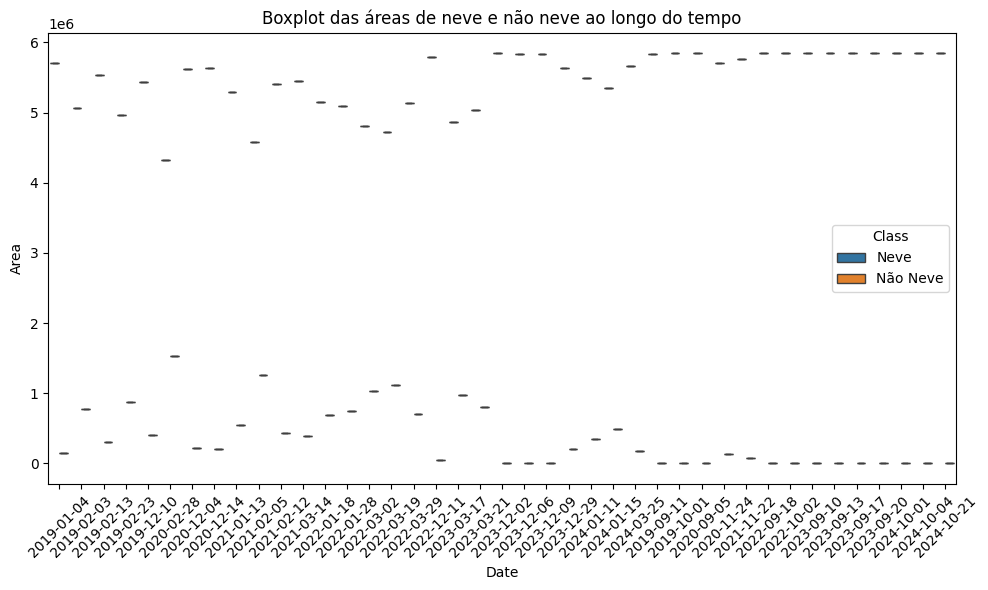

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Função para criar um DataFrame a partir dos resultados de neve e não neve
def create_snow_dataframe(results):
    """
    Converte os resultados de neve e não neve em um DataFrame.

    Parâmetros:
    results: lista de dicionários com as áreas de neve, não neve e datas.

    Retorno:
    DataFrame formatado com as colunas 'Date', 'Class' (Neve ou Não Neve) e 'Area'.
    """
    data = []
    for res in results:
        # Adicionar os dados de neve
        data.append({'Date': res['date'], 'Class': 'Neve', 'Area': res['snow_area']})
        # Adicionar os dados de não neve
        data.append({'Date': res['date'], 'Class': 'Não Neve', 'Area': res['non_snow_area']})

    # Converter para DataFrame
    df = pd.DataFrame(data)
    df['Date'] = pd.to_datetime(df['Date'])  # Converter a coluna de data para o formato datetime
    return df

# Função para criar o boxplot
def plot_snow_boxplot(df):
    """
    Cria um boxplot para áreas de neve e não neve ao longo do tempo.

    Parâmetros:
    df : DataFrame
        DataFrame com colunas 'Date', 'Class' (Neve ou Não Neve) e 'Area'.
    """
    # Criar o gráfico de boxplot
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='Date', y='Area', hue='Class', data=df)
    plt.xticks(rotation=45)
    plt.title('Boxplot das áreas de neve e não neve ao longo do tempo')
    plt.tight_layout()
    plt.show()

# Supondo que 'results' seja a lista de dicionários gerada pelas funções anteriores
df_snow = create_snow_dataframe(results)

# Criar o boxplot
plot_snow_boxplot(df_snow)


### Gráfico linhas

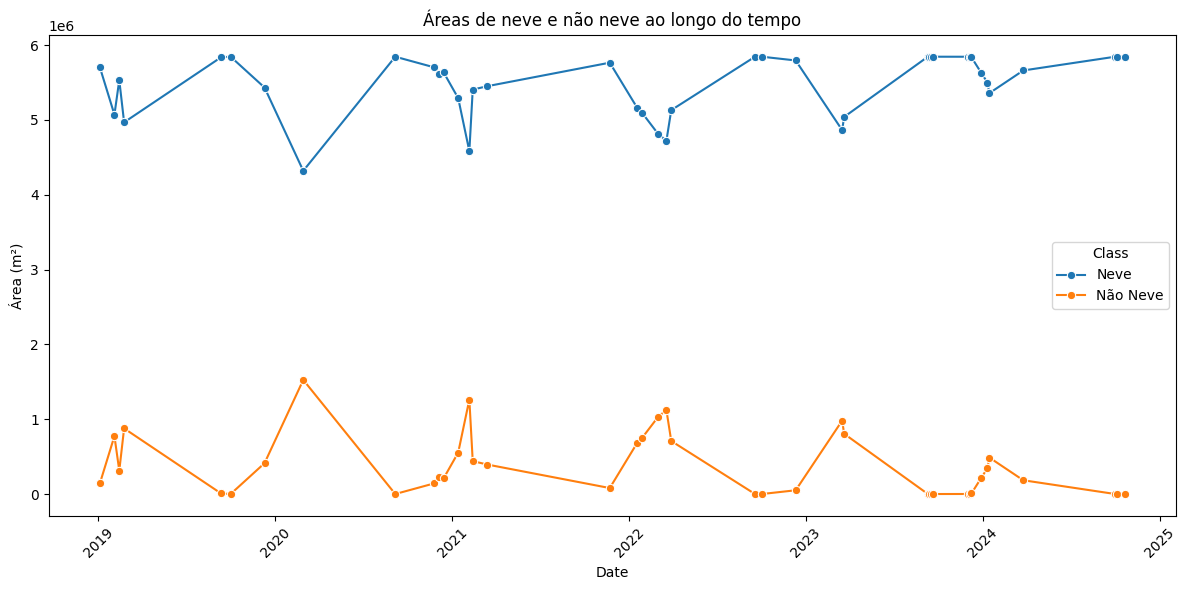

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_snow_lineplot(df):
#     """
#     Cria um gráfico de linhas para áreas de neve e não neve ao longo do tempo.

#     Parâmetros:
#     df : DataFrame
#         DataFrame com colunas 'Date', 'Class' (Neve ou Não Neve) e 'Area'.
#     """
#     plt.figure(figsize=(12, 6))

#     # Criar o gráfico de linhas para cada classe (Neve, Não Neve)
#     sns.lineplot(x='Date', y='Area', hue='Class', data=df, marker="o")

#     # Ajustar rótulos e título
#     plt.xticks(rotation=45)
#     plt.title('Áreas de neve e não neve ao longo do tempo')
#     plt.ylabel('Área (m²)')
#     plt.tight_layout()
#     plt.show()

# # Gerar o gráfico de linhas a partir do DataFrame
# plot_snow_lineplot(df_snow)


### Gráfico Barras

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns

# def plot_snow_barplot(df):
#     """
#     Cria um gráfico de barras para áreas de neve e não neve ao longo do tempo,
#     ordenando as datas em ordem crescente.

#     Parâmetros:
#     df : DataFrame
#         DataFrame com colunas 'Date', 'Class' (Neve ou Não Neve) e 'Area'.
#     """
#     # Converter a coluna 'Date' para o tipo datetime, se ainda não for
#     df['Date'] = pd.to_datetime(df['Date'])

#     # Ordenar o DataFrame pela coluna 'Date'
#     df = df.sort_values(by='Date')

#     plt.figure(figsize=(14, 8))

#     # Criar o gráfico de barras para cada classe (Neve, Não Neve)
#     sns.barplot(x='Date', y='Area', hue='Class', data=df)

#     # Ajustar rótulos e título
#     plt.xticks(rotation=45, ha='right')  # Rotacionar os rótulos das datas para melhor visualização
#     plt.title('Áreas de neve e não neve ao longo do tempo')
#     plt.ylabel('Área (m²)')
#     plt.tight_layout()
#     plt.show()

# # Gerar o gráfico de barras a partir do DataFrame
# plot_snow_barplot(df_snow)


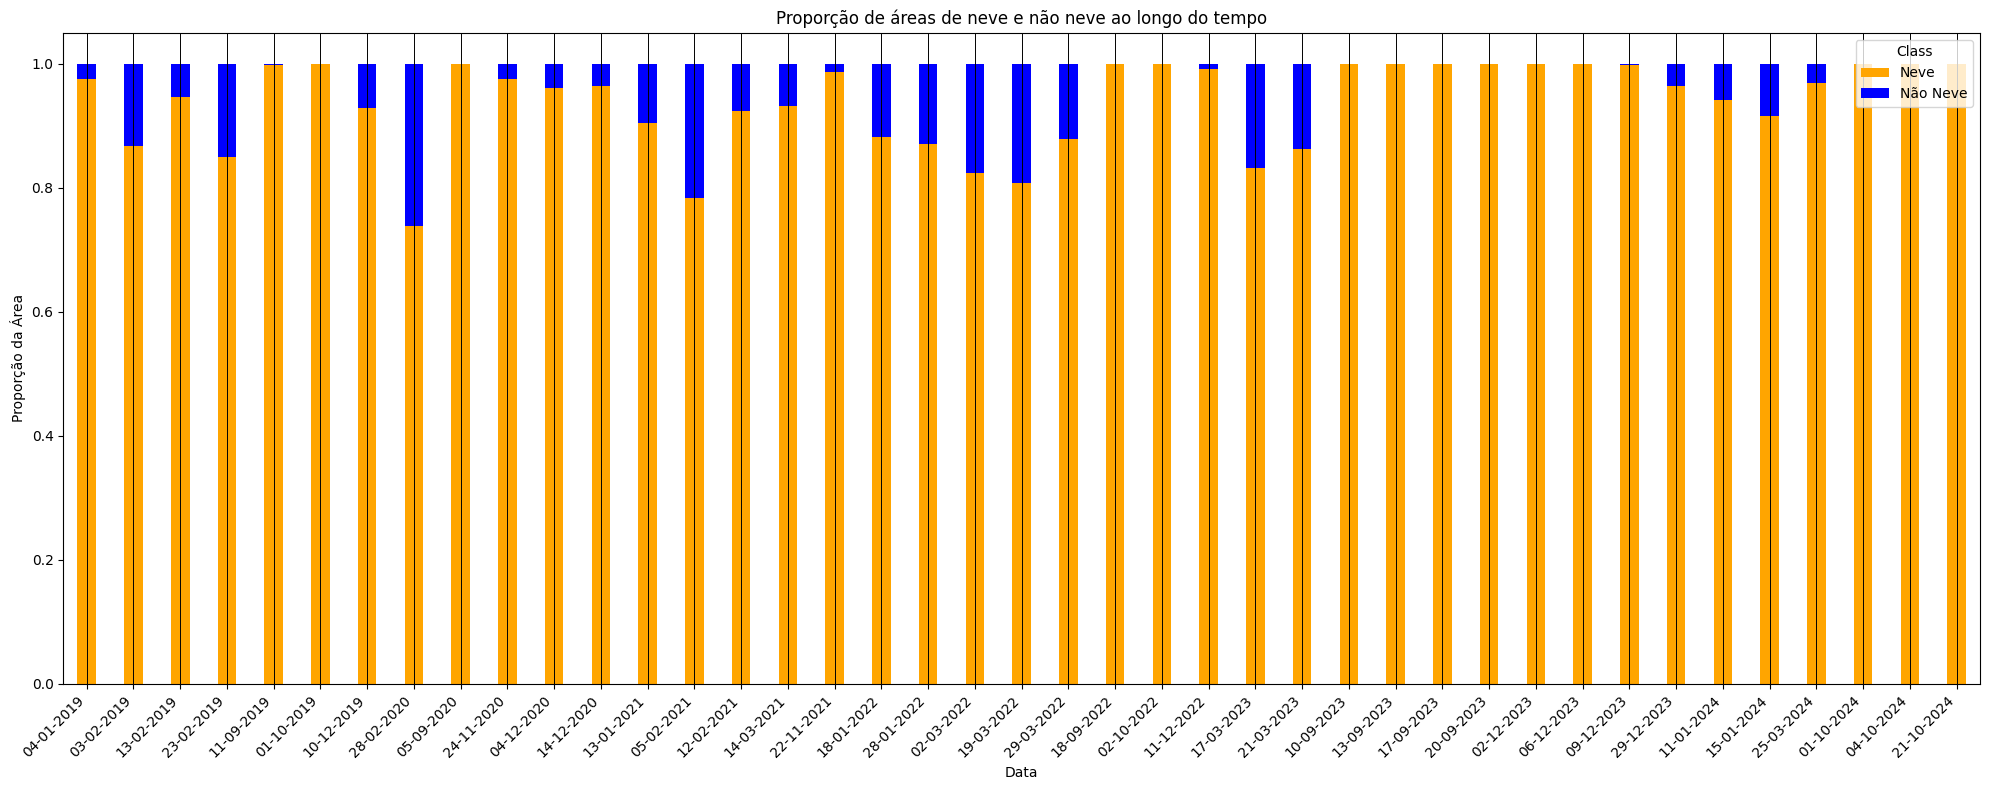

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_snow_stacked_barplot(df):
    """
    Cria um gráfico de barras empilhadas para áreas de neve e não neve ao longo do tempo,
    organizando as datas em uma escala temporal representativa.

    Parâmetros:
    df : DataFrame
        DataFrame com colunas 'Date', 'Class' (Neve ou Não Neve) e 'Area'.
    """
    # Converter a coluna 'Date' para o tipo datetime e ordenar o DataFrame pela coluna 'Date'
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date')

    # Somar áreas por data e classe para evitar duplicação
    df = df.groupby(['Date', 'Class'], as_index=False)['Area'].sum()

    # Converter as áreas em proporções
    df['Area'] = df.groupby('Date')['Area'].transform(lambda x: x / x.sum())

    # Pivotar o DataFrame para ter classes como colunas
    df_pivot = df.pivot(index='Date', columns='Class', values='Area').fillna(0)

    # Configurar o tamanho do gráfico com uma largura maior para criar o espaçamento necessário
    plt.figure(figsize=(20, 8))

    # Plotar o gráfico de barras empilhadas com a distribuição temporal
    df_pivot.plot(kind='bar', stacked=True, color=['orange', 'blue'], width=0.4, ax=plt.gca())  # Aumentar a largura da coluna

    # Ajustes de título e rótulos
    plt.title('Proporção de áreas de neve e não neve ao longo do tempo')
    plt.ylabel('Proporção da Área')
    plt.xlabel('Data')

    # Configurar o eixo X com dia, mês e ano para cada entrada
    plt.gca().set_xticks(range(len(df_pivot.index)))
    plt.gca().set_xticklabels([date.strftime('%d-%m-%Y') for date in df_pivot.index], rotation=45, ha='right')
    plt.xlim(-0.5, len(df_pivot) - 0.5)  # Ajustar os limites do eixo X para manter a escala correta entre as datas

    # Adicionar grade menor para separar anos
    plt.gca().xaxis.grid(True, which='minor', color='gray', linestyle='--', linewidth=0.5)
    plt.gca().xaxis.grid(True, which='major', color='black', linestyle='-', linewidth=0.7)

    # Ajustar o layout para visualização
    plt.tight_layout()
    plt.show()

# Gerar o gráfico de barras empilhadas a partir do DataFrame
plot_snow_stacked_barplot(df_snow)


# **PARQUET**

In [ ]:
df_snow.to_parquet("df_snow.parquet")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os

# Defina o caminho da pasta no Google Drive
caminho_drive = '/content/drive/MyDrive/meus_parquets/'

# Crie o diretório, se não existir
os.makedirs(caminho_drive, exist_ok=True)

# Salve o DataFrame como arquivo Parquet no Google Drive
df_snow.to_parquet(caminho_drive + "df_snow.parquet")
